# TEAM 44 - HCC Survival (U05)

This is the first part of the first lab assignment of the course "Neural Networks and Intelligent Systems" at the National Technical University of Athens.

**Team 44** consists of **George Kyriakopoulos** (03118153) and **Serafeim Tzelepis** (03118849).

## Packages and imports

In [ ]:
%pip install pip --upgrade
%pip install scikit-learn --upgrade
%pip install numpy --upgrade
%pip install matplotlib --upgrade
%pip install imbalanced-learn --upgrade
%pip install pandas --upgrade
%pip install tabulate --upgrade
%pip install seaborn --upgrade

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

## Intoduction and Overview

For this part we will use a UCI dataset, [HCC Survival](https://archive.ics.uci.edu/ml/datasets/HCC+Survival).

HCC dataset was obtained at a University Hospital in Portugal and contais several demographic, risk factors, laboratory and overall survival features of 165 real patients diagnosed with HCC. The dataset contains 49 features selected according to the EASL-EORTC (European Association for the Study of the Liver - European Organisation for Research and Treatment of Cancer) Clinical Practice Guidelines, which are the current state-of-the-art on the management of HCC.

This is an heterogeneous dataset, with 23 quantitative variables, and 26 qualitative variables. Overall, missing data represents 10.22% of the whole dataset and only eight patients have complete information in all fields (4.85%). The target variables is the survival at 1 year, and was encoded as a binary variable: 0 (dies) and 1 (lives). A certain degree of class-imbalance is also present (63 cases labeled as dies and 102 as lives).

In [3]:
# get hcc_data.txt file
!wget -q http://archive.ics.uci.edu/ml/machine-learning-databases/00423/hcc-survival.zip -P resources
!unzip -q resources/hcc-survival.zip -d resources
!rm resources/hcc-survival.zip
!rm -r resources/__MACOSX
!mv resources/hcc-survival/hcc-data.txt resources/hcc-data.txt
!mv resources/hcc-survival/hcc-description.txt resources/hcc-description.txt
!rm -r resources/hcc-survival

# read data from hcc_data.txt file and replace missing values with NaN
df = pd.read_csv("resources/hcc-data.txt", header=None, na_values = '?')

# print basic info about dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       165 non-null    int64  
 1   1       147 non-null    float64
 2   2       165 non-null    int64  
 3   3       148 non-null    float64
 4   4       126 non-null    float64
 5   5       141 non-null    float64
 6   6       156 non-null    float64
 7   7       165 non-null    int64  
 8   8       126 non-null    float64
 9   9       124 non-null    float64
 10  10      162 non-null    float64
 11  11      155 non-null    float64
 12  12      142 non-null    float64
 13  13      162 non-null    float64
 14  14      163 non-null    float64
 15  15      151 non-null    float64
 16  16      143 non-null    float64
 17  17      113 non-null    float64
 18  18      150 non-null    float64
 19  19      154 non-null    float64
 20  20      162 non-null    float64
 21  21      161 non-null    float64
 22  22

The only transformation applied to the original dataset was the replacement of missing values (denoted by "?") by NaN value, using the pandas.read_csv function with the na_values parameter.

There are 165 samples and 49 features in the dataset. The types of the features are as follows:

* Gender: nominal
* Symptoms: nominal
* Alcohol: nominal
* Hepatitis B Surface Antigen: nominal
* Hepatitis B e Antigen: nominal
* Hepatitis B Core Antibody: nominal
* Hepatitis C Virus Antibody: nominal
* Cirrhosis : nominal
* Endemic Countries: nominal
* Smoking: nominal
* Diabetes: nominal
* Obesity: nominal
* Hemochromatosis: nominal
* Arterial Hypertension: nominal
* Chronic Renal Insufficiency: nominal
* Human Immunodeficiency Virus: nominal
* Nonalcoholic Steatohepatitis: nominal
* Esophageal Varices: nominal
* Splenomegaly: nominal
* Portal Hypertension: nominal
* Portal Vein Thrombosis: nominal
* Liver Metastasis: nominal
* Radiological Hallmark: nominal
* Age at diagnosis: integer
* Grams of Alcohol per day: continuous
* Packs of cigarets per year: continuous
* Performance Status: ordinal
* Encefalopathy degree: ordinal
* Ascites degree: ordinal
* International Normalised Ratio: continuous
* Alpha-Fetoprotein (ng/mL): continuous
* Haemoglobin (g/dL): continuous
* Mean Corpuscular Volume (fl): continuous
* Leukocytes(G/L): continuous
* Platelets (G/L): continuous
* Albumin (mg/dL): continuous
* Total Bilirubin(mg/dL): continuous
* Alanine transaminase (U/L): continuous
* Aspartate transaminase (U/L): continuous
* Gamma glutamyl transferase (U/L): continuous
* Alkaline phosphatase (U/L): continuous
* Total Proteins (g/dL): continuous
* Creatinine (mg/dL): continuous
* Number of Nodules: integer
* Major dimension of nodule (cm): continuous
* Direct Bilirubin (mg/dL): continuous
* Iron (mcg/dL): continuous
* Oxygen Saturation (%): continuous
* Ferritin (ng/mL): continuous

All the nominal features (the first 23) are not ordinal features.

There are no labels for the features and no row indexing.

The last column (50th) is the label of the classes, which is the survival at 1 year, and was encoded as a binary variable: 0 (dies) and 1 (lives).

In [4]:
# slice the dataframe to split the features from the labels
labels_df = df.iloc[:, -1]
labels = labels_df.values.reshape(165)
features_df = df.iloc[:, :-1]
features = features_df.values

# print info needed to answer the questions
print(f"Number of samples with missing values: {features_df.isnull().values.any(axis=1).sum()}")
print(f"Percentage of samples with missing values: {np.format_float_positional(features_df.isnull().values.any(axis=1).sum()/features_df.shape[0]*100, 2)}%")
print(f"Percentage of missing values to total number of values: {np.format_float_positional(features_df.isnull().values.sum()/features_df.size*100, 2)}%")

print(f"Class frequencies: {np.bincount(labels)}")
print(f"Percentage of negative samples: {np.format_float_positional(np.bincount(labels)[0]/labels.shape[0]*100, 2)}%")
print(f"Percentage of positive samples: {np.format_float_positional(np.bincount(labels)[1]/labels.shape[0]*100, 2)}%")
print(f"Class frequency ratio: {np.format_float_positional(np.max(np.bincount(labels))/np.min(np.bincount(labels)), 2)}")

Number of samples with missing values: 157
Percentage of samples with missing values: 95.15%
Percentage of missing values to total number of values: 10.22%
Class frequencies: [ 63 102]
Percentage of negative samples: 38.18%
Percentage of positive samples: 61.82%
Class frequency ratio: 1.62


There are missing values. The number of samples with missing values is 157, and their percentage with respect to total number of samples is 95.15%. The missing data represents 10.22% of the whole dataset.

There are 63 cases labeled as dies and 102 as lives, with 38.18% and 61.82% respectively. This is a class-imbalanced binary dataset, as the 60%-40% ratio is not respected, as showcased by the class frequency ratio with a value over 1.5.

## Preparation

In [5]:
# split the data into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [6]:
# use 3 imputers with most frequent, mean and median strategies
imp1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp2 = SimpleImputer(missing_values=np.nan, strategy='mean')
imp3 = SimpleImputer(missing_values=np.nan, strategy='median')

# masks for different types of data
mask1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 28]
mask2 = [24, 25, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48]
mask3 = [23, 43]
imp1.fit(X_train[:, mask1])
imp2.fit(X_train[:, mask2])
imp3.fit(X_train[:, mask3])

# impute missing values with above strategies
X_train[:, mask1] = imp1.transform(X_train[:, mask1])
X_train[:, mask2] = imp2.transform(X_train[:, mask2])
X_train[:, mask3] = imp3.transform(X_train[:, mask3])
X_test[:, mask1] = imp1.transform(X_test[:, mask1])
X_test[:, mask2] = imp2.transform(X_test[:, mask2])
X_test[:, mask3] = imp3.transform(X_test[:, mask3])

For the missing values we will use the SimpleImputer class from the sklearn.impute module. We will use the most frequentm, mean and the median strategy. The most frequent strategy replaces missing values using the most frequent value along each column, the mean strategy replaces missing values using the mean value along each column, while the median strategy replaces missing values using the median value along each column.

We used the most frequent strategy on the nominal and ordinal features, the mean strategy on the continuous features and the median value on the integer features.

In [7]:
# create pandas dataframes for the train and test data
train_data = pd.DataFrame(X_train)
test_data = pd.DataFrame(X_test)

# concat the train and test data and create dummy features for the nominal ones
data = pd.concat([train_data, test_data], axis=0)
data = pd.get_dummies(data, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

# split the data to train and test again with 70-30 ratio
X_train = data.iloc[0:115, :].values
X_test = data.iloc[115:165, :].values

print(f"Number of samples and features of X_train data: {X_train.shape}")
print(f"Number of samples and features of X_test data: {X_test.shape}")

Number of samples and features of X_train data: (115, 72)
Number of samples and features of X_test data: (50, 72)


For the nominal features we will use the get_dummies function from the pandas module. This function is used to convert categorical variable into dummy/indicator variables.

We had to concat the train and test data so that the dummy/indicator variables end up being the same for both sets. We then split the data back into train and test sets, following the initial 70-30 ratio.

## Classification

### Out of the box

In [ ]:
# classifiers
DC = DummyClassifier()
GNB = GaussianNB()
KNN = KNeighborsClassifier()
LR = LogisticRegression()

# dictionaries for results
names = {}
ootb_accuracy = {}
ootb_f1 = {}
ootb_accuracy_cv = {}
ootb_f1_cv = {}

# names of classifiers
names['DC'] = 'Dummy Classifier'
names['GNB'] = 'Gaussian Naive Bayes'
names['KNN'] = 'K-Nearest Neighbors'
names['LR'] = 'Logistic Regression'

# fit the classifiers
DC.fit(X_train, y_train)
GNB.fit(X_train, y_train)
KNN.fit(X_train, y_train)
LR.fit(X_train, y_train)

# predict
y_pred_DC = DC.predict(X_test)
y_pred_GNB = GNB.predict(X_test)
y_pred_KNN = KNN.predict(X_test)
y_pred_LR = LR.predict(X_test)

# accuracy
ootb_accuracy['DC'] = accuracy_score(y_test, y_pred_DC)
ootb_accuracy['GNB'] = accuracy_score(y_test, y_pred_GNB)
ootb_accuracy['KNN'] = accuracy_score(y_test, y_pred_KNN)
ootb_accuracy['LR'] = accuracy_score(y_test, y_pred_LR)

# f1 score
ootb_f1['DC'] = f1_score(y_test, y_pred_DC)
ootb_f1['GNB'] = f1_score(y_test, y_pred_GNB)
ootb_f1['KNN'] = f1_score(y_test, y_pred_KNN)
ootb_f1['LR'] = f1_score(y_test, y_pred_LR)

# 10-fold cross validation accuracy
ootb_accuracy_cv['DC'] = cross_val_score(DC, X_train, y_train, cv=10, scoring='accuracy').mean()
ootb_accuracy_cv['GNB'] = cross_val_score(GNB, X_train, y_train, cv=10, scoring='accuracy').mean()
ootb_accuracy_cv['KNN'] = cross_val_score(KNN, X_train, y_train, cv=10, scoring='accuracy').mean()
ootb_accuracy_cv['LR'] = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy').mean()

# 10-fold cross validation f1 score
ootb_f1_cv['DC'] = cross_val_score(DC, X_train, y_train, cv=10, scoring='f1').mean()
ootb_f1_cv['GNB'] = cross_val_score(GNB, X_train, y_train, cv=10, scoring='f1').mean()
ootb_f1_cv['KNN'] = cross_val_score(KNN, X_train, y_train, cv=10, scoring='f1').mean()
ootb_f1_cv['LR'] = cross_val_score(LR, X_train, y_train, cv=10, scoring='f1').mean()

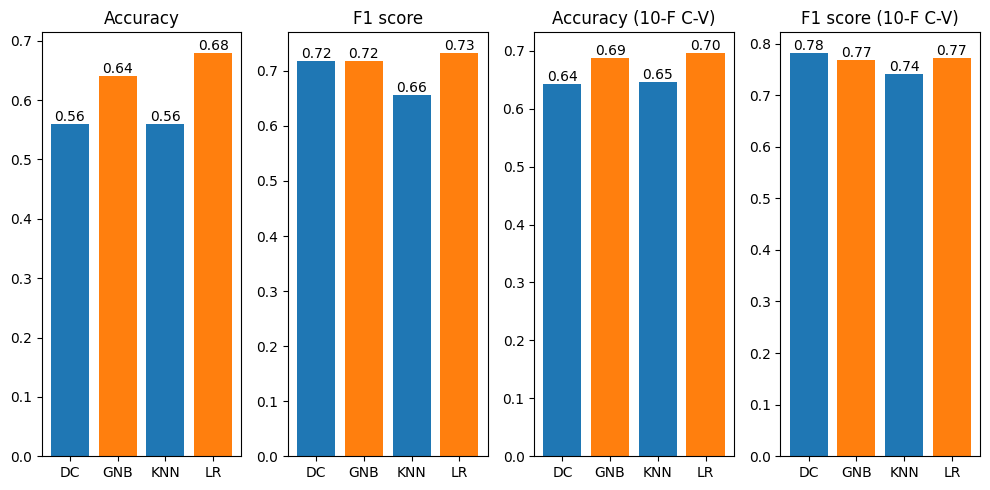

╭──────────────────────┬────────────┬────────────┬───────────────────────────────────────┬───────────────────────────────────────╮
│ Classifier           │   Accuracy │   F1 score │   Accuracy (10-Fold Cross-Validation) │   F1 score (10-Fold Cross-Validation) │
├──────────────────────┼────────────┼────────────┼───────────────────────────────────────┼───────────────────────────────────────┤
│ Dummy Classifier     │       0.56 │       0.72 │                                  0.64 │                                  0.78 │
├──────────────────────┼────────────┼────────────┼───────────────────────────────────────┼───────────────────────────────────────┤
│ Gaussian Naive Bayes │       0.64 │       0.72 │                                  0.69 │                                  0.77 │
├──────────────────────┼────────────┼────────────┼───────────────────────────────────────┼───────────────────────────────────────┤
│ K-Nearest Neighbors  │       0.56 │       0.66 │                                 

In [27]:
color = 2 * ['tab:blue', 'tab:orange']

# bar plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.bar(range(len(ootb_accuracy)), list(ootb_accuracy.values()), align='center', color=color)
plt.xticks(range(len(ootb_accuracy)), list(ootb_accuracy.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title("Accuracy")

# bar plot f1 score
plt.subplot(1, 4, 2)
plt.bar(range(len(ootb_f1)), list(ootb_f1.values()), align='center', color=color)
plt.xticks(range(len(ootb_f1)), list(ootb_f1.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title("F1 score")

# bar plot cross validation accuracy
plt.subplot(1, 4, 3)
plt.bar(range(len(ootb_accuracy_cv)), list(ootb_accuracy_cv.values()), align='center', color=color)
plt.xticks(range(len(ootb_accuracy_cv)), list(ootb_accuracy_cv.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title("Accuracy (10-F C-V)")

# bar plot cross validation f1 score
plt.subplot(1, 4, 4)
plt.bar(range(len(ootb_f1_cv)), list(ootb_f1_cv.values()), align='center', color=color)
plt.xticks(range(len(ootb_f1_cv)), list(ootb_f1_cv.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title("F1 score (10-F C-V)")
plt.tight_layout()
plt.show()

# print table
headers = ["Classifier", "Accuracy", "F1 score", "Accuracy (10-Fold Cross-Validation)", "F1 score (10-Fold Cross-Validation)"]
data = [row for row in zip(names.values(), ootb_accuracy.values(), ootb_f1.values(), ootb_accuracy_cv.values(), ootb_f1_cv.values())]
print(tabulate(data, headers=headers, tablefmt='rounded_grid', floatfmt=".2f"))

When using just a **fit and predict** on the data we can see that for both the accuracy and the F1 score metrics, the out of the box Logistic Regression model performs the best with 0.68 and 0.73 respectively. The OOTB Dummy Classifier scores a 0.56 accuracy, same as the OOTBE K-Nearest Neighbors, while the Gaussian Naive Bayes scores somewhere in between these and the LR, with a 0.64 accuracy. On the F1 score metric, however, the GNB model has a 0.72 F1 score, same with the DC, while the KNN has the worst score again, with a 0.66.

When using a **10-Fold Cross Validation** on the train data, the LR model still barely has the best accuracy with a 0.70 mark, while GNB keeps the second best with a 0.69, leaving KNN and DC behind with a 0.65 and 0.64 accuracy, respectively. On the F1 score, however, the DC model has the best score with a 0.78, followed by the GNB and LR models with a 0.77, while KNN is again last with a 0.74 F1 score.

We can, therefore, say that the **Logistic Regression model performs the best** in almost every metric, followed by the Gaussian Naive Bayes model, while the K-Nearest Neighbors and the Dummy Classifier models perform the worst. A reason behind the LR model beating the GNB is that the second one assumes that the features are independent, which is most likely not the case with the features in this dataset.

### Optimization

#### Initializations and Feature Variance

In [10]:
# default transformers initialization
selector = VarianceThreshold()
standard = StandardScaler()
min_max = MinMaxScaler()
ros = RandomOverSampler()
rus = RandomUnderSampler()
pca = PCA()

# dictionaries to store results
optimized_accuracy_acc = {}
optimized_accuracy_f1 = {}
optimized_f1_acc = {}
optimized_f1_f1 = {}
train_time_acc = {}
train_time_f1 = {}
test_time_acc = {}
test_time_f1 = {}

In [11]:
# check variance to select variance threshold values
train_variance = X_train.var(axis=0)
print(f"- Train data feature variance: \n {train_variance}")
print(f"--------------------------------------------------------------------------------")
print(f"- Minimum, maximum, mean and median variance:")
print(f"{np.min(train_variance)}, {np.max(train_variance)}, {np.mean(train_variance)}, {np.median(train_variance)}")

- Train data feature variance: 
 [1.64624877e+02 3.05626153e+03 2.40905482e+03 1.31901701e+00
 1.95841210e-01 4.38109641e-01 2.26191276e-01 2.97372702e+10
 4.26148758e+00 6.67759503e+01 7.83600146e+06 1.17003133e+10
 4.66437542e-01 3.09651575e+01 3.88658315e+03 8.74963408e+03
 7.25871759e+04 2.20287249e+04 4.51130837e+01 7.72392482e-01
 3.11107750e+00 2.39464855e+01 1.47037101e+01 1.63326985e+03
 3.89578659e+02 9.71297112e+04 1.37920605e-01 1.37920605e-01
 2.21247637e-01 2.21247637e-01 1.88582231e-01 1.88582231e-01
 9.34593573e-02 9.34593573e-02 0.00000000e+00 0.00000000e+00
 1.74971645e-01 1.74971645e-01 1.60000000e-01 1.60000000e-01
 8.65028355e-02 8.65028355e-02 6.47258979e-02 6.47258979e-02
 2.29413989e-01 2.29413989e-01 2.24120983e-01 2.24120983e-01
 1.06918715e-01 1.06918715e-01 4.15879017e-02 4.15879017e-02
 2.24120983e-01 2.24120983e-01 7.93950851e-02 7.93950851e-02
 2.54064272e-02 2.54064272e-02 4.94517958e-02 4.94517958e-02
 1.70132325e-01 1.70132325e-01 2.41663516e-01 2.4166

#### Dummy Classifier

For the Dummy Classifier there is no optimization to be done. Therefore we just fit the default one on the train data and evaluate it on the test data to get the accuracy, F1 score, train and test time.

In [12]:
# get fit and predict times on test data
start = time.time()
DC.fit(X_train, y_train)
end = time.time()
train_time_acc['DC'] = end - start
train_time_f1['DC'] = end - start

start = time.time()
y_preds = DC.predict(X_test)
end = time.time()
test_time_acc['DC'] = end - start
test_time_f1['DC'] = end - start

# get accuracy and f1 score on test data
optimized_accuracy_acc['DC'] = accuracy_score(y_test, y_preds)
optimized_accuracy_f1['DC'] = accuracy_score(y_test, y_preds)
optimized_f1_acc['DC'] = f1_score(y_test, y_preds)
optimized_f1_f1['DC'] = f1_score(y_test, y_preds)

# print accuracy and f1 score
print(f"Accuracy: {np.format_float_positional(optimized_accuracy_acc['DC'], 2)}")
print(f"F1 score: {np.format_float_positional(optimized_f1_acc['DC'], 2)}")

# print fit and predict times
print(f"Time to fit: {np.format_float_positional(train_time_acc['DC'], 5)} sec")
print(f"Time to predict: {np.format_float_positional(test_time_acc['DC'], 5)} sec")

Accuracy: 0.56
F1 score: 0.72
Time to fit: 0.00078 sec
Time to predict: 0.00017 sec


#### Gaussian Naive Bayes

In [13]:
# initialize pipeline and grid search for accuracy
pipe_acc = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('pca', pca), ('classifier', GNB)], memory='tmp')
threshold_acc = [0.17, 0.18, 0.2, 0.21]
n_components_acc = [10, 12, 13, 14, 16, 18]
var_smoothing_acc = [0, 1e-9, 1]

estimator_acc = GridSearchCV(pipe_acc, dict(selector__threshold=threshold_acc, pca__n_components=n_components_acc, classifier__var_smoothing=var_smoothing_acc), cv=10, scoring='accuracy', n_jobs=-1)
estimator_acc.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_acc.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"accuracy: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, n_components: {results.iloc[i, 1]['pca__n_components']}, var_smoothing: {results.iloc[i, 1]['classifier__var_smoothing']}")

accuracy: 0.7652, threshold: 0.17, n_components: 16, var_smoothing: 0
accuracy: 0.7652, threshold: 0.17, n_components: 13, var_smoothing: 1e-09
accuracy: 0.7652, threshold: 0.17, n_components: 16, var_smoothing: 1e-09
accuracy: 0.7652, threshold: 0.17, n_components: 13, var_smoothing: 0
accuracy: 0.7561, threshold: 0.18, n_components: 13, var_smoothing: 0
accuracy: 0.7561, threshold: 0.18, n_components: 13, var_smoothing: 1e-09
accuracy: 0.7561, threshold: 0.18, n_components: 14, var_smoothing: 0
accuracy: 0.7561, threshold: 0.18, n_components: 14, var_smoothing: 1e-09
accuracy: 0.7553, threshold: 0.17, n_components: 14, var_smoothing: 0


In [28]:
# initialize pipeline and grid search for f1 score
pipe_f1 = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('pca', pca), ('classifier', GNB)], memory='tmp')
threshold_f1 = [0.2, 1.1, 1.11, 1.12]
n_components_f1 = [10, 11, 12, 19, 20]
var_smoothing_f1 = [1]

estimator_f1 = GridSearchCV(pipe_f1, dict(selector__threshold=threshold_f1, pca__n_components=n_components_f1, classifier__var_smoothing=var_smoothing_f1), cv=10, scoring='f1', n_jobs=-1)
estimator_f1.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_f1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"f1: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, n_components: {results.iloc[i, 1]['pca__n_components']}, var_smoothing: {results.iloc[i, 1]['classifier__var_smoothing']}")

f1: 0.8173, threshold: 0.2, n_components: 19, var_smoothing: 1
f1: 0.8142, threshold: 0.2, n_components: 20, var_smoothing: 1
f1: 0.8104, threshold: 1.12, n_components: 20, var_smoothing: 1
f1: 0.8104, threshold: 1.11, n_components: 20, var_smoothing: 1
f1: 0.8104, threshold: 1.1, n_components: 20, var_smoothing: 1
f1: 0.8104, threshold: 1.12, n_components: 19, var_smoothing: 1
f1: 0.8104, threshold: 1.11, n_components: 19, var_smoothing: 1
f1: 0.8104, threshold: 1.1, n_components: 19, var_smoothing: 1
f1: 0.8104, threshold: 0.2, n_components: 11, var_smoothing: 1


In [15]:
zipped = zip(["Accuracy", "F1 score"],
             [estimator_acc, estimator_f1],
             [train_time_acc, train_time_f1],
             [test_time_acc, test_time_f1],
             [optimized_accuracy_acc, optimized_accuracy_f1],
             [optimized_f1_acc, optimized_f1_f1])

for scoring, estimator, train_time, test_time, optimized_accuracy, optimized_f1 in zipped:
    # get fit and predict times on test data
    start = time.time()
    estimator.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time['GNB'] = end - start

    start = time.time()
    y_preds = estimator.best_estimator_.predict(X_test)
    end = time.time()
    test_time['GNB'] = end - start
    
    # get accuracy and f1 score on test data
    optimized_accuracy['GNB'] = accuracy_score(y_test, y_preds)
    optimized_f1['GNB'] = f1_score(y_test, y_preds)

    # print best estimator
    print(f"- Gaussian Naive Bayes model selection based on {scoring}")
    print(f"Best estimator: {estimator.best_estimator_.steps}")
    print(f"{scoring} (10-Fold Cross-Validation): {np.format_float_positional(estimator.best_score_, 2)}")

    # print accuracy and f1 score
    print(f"Accuracy: {np.format_float_positional(optimized_accuracy['GNB'], 2)}")
    print(f"F1 score: {np.format_float_positional(optimized_f1['GNB'], 2)}")

    # print fit and predict times
    print(f"Time to fit: {np.format_float_positional(train_time['GNB'], 5)} sec")
    print(f"Time to predict: {np.format_float_positional(test_time['GNB'], 5)} sec")

    if estimator != estimator_f1:
        print(f"--------------------------------------------------------------------------------")

# after finding out that its the worst estimator based on accuracy we keep it for the confusion matrix
worst_estimator = estimator_f1.best_estimator_

- Gaussian Naive Bayes model selection based on Accuracy
Best estimator: [('selector', VarianceThreshold(threshold=0.17)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('pca', PCA(n_components=13)), ('classifier', GaussianNB(var_smoothing=0))]
Accuracy (10-Fold Cross-Validation): 0.77
Accuracy: 0.72
F1 score: 0.78
Time to fit: 0.04159 sec
Time to predict: 0.00405 sec
--------------------------------------------------------------------------------
- Gaussian Naive Bayes model selection based on F1 score
Best estimator: [('selector', VarianceThreshold(threshold=0.2)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('pca', PCA(n_components=19)), ('classifier', GaussianNB(var_smoothing=1))]
F1 score (10-Fold Cross-Validation): 0.82
Accuracy: 0.62
F1 score: 0.74
Time to fit: 0.02528 sec
Time to predict: 0.00543 sec


#### K-Nearest Neighbors

In [16]:
# initialize pipeline and grid search for accuracy
pipe_acc = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('pca', pca), ('classifier', KNN)], memory='tmp')
threshold_acc = [0.42, 0.43, 0.44]
n_components_acc = [5]
n_neighbors_acc = [60, 63]
weights_acc = ['distance']
metric_acc = ['minkowski', 'euclidean']

estimator_acc = GridSearchCV(pipe_acc, dict(selector__threshold=threshold_acc, pca__n_components=n_components_acc, classifier__n_neighbors=n_neighbors_acc, classifier__weights=weights_acc, classifier__metric=metric_acc), cv=10, scoring='accuracy', n_jobs=-1)
estimator_acc.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_acc.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"accuracy: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, n_components: {results.iloc[i, 1]['pca__n_components']}, n_neighbors: {results.iloc[i, 1]['classifier__n_neighbors']}, weights: {results.iloc[i, 1]['classifier__weights']}, metric: {results.iloc[i, 1]['classifier__metric']}")

accuracy: 0.7500, threshold: 0.42, n_components: 5, n_neighbors: 63, weights: distance, metric: minkowski
accuracy: 0.7500, threshold: 0.43, n_components: 5, n_neighbors: 63, weights: distance, metric: minkowski
accuracy: 0.7500, threshold: 0.42, n_components: 5, n_neighbors: 63, weights: distance, metric: euclidean
accuracy: 0.7500, threshold: 0.43, n_components: 5, n_neighbors: 63, weights: distance, metric: euclidean
accuracy: 0.75, threshold: 0.42, n_components: 5, n_neighbors: 60, weights: distance, metric: minkowski
accuracy: 0.75, threshold: 0.43, n_components: 5, n_neighbors: 60, weights: distance, metric: minkowski
accuracy: 0.75, threshold: 0.42, n_components: 5, n_neighbors: 60, weights: distance, metric: euclidean
accuracy: 0.75, threshold: 0.43, n_components: 5, n_neighbors: 60, weights: distance, metric: euclidean
accuracy: 0.7235, threshold: 0.44, n_components: 5, n_neighbors: 60, weights: distance, metric: minkowski


In [29]:
# initialize pipeline and grid search for f1 score
pipe_f1 = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('pca', pca), ('classifier', KNN)], memory='tmp')
threshold_f1 = [0.58, 0.59, 0.6, 0.61]
n_components_f1 = [5]
n_neighbors_f1 = [68, 69, 70]
weights_f1 = ['distance']
metric_f1 = ['minkowski', 'euclidean']

estimator_f1 = GridSearchCV(pipe_f1, dict(selector__threshold=threshold_f1, pca__n_components=n_components_f1, classifier__n_neighbors=n_neighbors_f1, classifier__weights=weights_f1, classifier__metric=metric_f1), cv=10, scoring='f1', n_jobs=-1)
estimator_f1.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_f1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"f1: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, n_components: {results.iloc[i, 1]['pca__n_components']}, n_neighbors: {results.iloc[i, 1]['classifier__n_neighbors']}, weights: {results.iloc[i, 1]['classifier__weights']}, metric: {results.iloc[i, 1]['classifier__metric']}")

f1: 0.8176, threshold: 0.58, n_components: 5, n_neighbors: 68, weights: distance, metric: minkowski
f1: 0.8176, threshold: 0.59, n_components: 5, n_neighbors: 68, weights: distance, metric: minkowski
f1: 0.8176, threshold: 0.6, n_components: 5, n_neighbors: 70, weights: distance, metric: euclidean
f1: 0.8176, threshold: 0.59, n_components: 5, n_neighbors: 70, weights: distance, metric: euclidean
f1: 0.8176, threshold: 0.58, n_components: 5, n_neighbors: 70, weights: distance, metric: euclidean
f1: 0.8176, threshold: 0.61, n_components: 5, n_neighbors: 69, weights: distance, metric: euclidean
f1: 0.8176, threshold: 0.6, n_components: 5, n_neighbors: 69, weights: distance, metric: euclidean
f1: 0.8176, threshold: 0.59, n_components: 5, n_neighbors: 69, weights: distance, metric: euclidean
f1: 0.8176, threshold: 0.58, n_components: 5, n_neighbors: 69, weights: distance, metric: euclidean


In [18]:
zipped = zip(["Accuracy", "F1 score"],
             [estimator_acc, estimator_f1],
             [train_time_acc, train_time_f1],
             [test_time_acc, test_time_f1],
             [optimized_accuracy_acc, optimized_accuracy_f1],
             [optimized_f1_acc, optimized_f1_f1])

for scoring, estimator, train_time, test_time, optimized_accuracy, optimized_f1 in zipped:
    # get fit and predict times on test data
    start = time.time()
    estimator.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time['KNN'] = end - start

    start = time.time()
    y_preds = estimator.best_estimator_.predict(X_test)
    end = time.time()
    test_time['KNN'] = end - start
    
    # get accuracy and f1 score on test data
    optimized_accuracy['KNN'] = accuracy_score(y_test, y_preds)
    optimized_f1['KNN'] = f1_score(y_test, y_preds)

    # print best estimator
    print(f"- K-Nearest Neighbors model selection based on {scoring}")
    print(f"Best estimator: {estimator.best_estimator_.steps}")
    print(f"{scoring} (10-Fold Cross-Validation): {np.format_float_positional(estimator.best_score_, 2)}") 

    # print accuracy and f1 score
    print(f"Accuracy: {np.format_float_positional(optimized_accuracy['KNN'], 2)}")
    print(f"F1 score: {np.format_float_positional(optimized_f1['KNN'], 2)}")

    # print fit and predict times
    print(f"Time to fit: {np.format_float_positional(train_time['KNN'], 5)} sec")
    print(f"Time to predict: {np.format_float_positional(test_time['KNN'], 5)} sec")

    if estimator != estimator_f1:
        print(f"--------------------------------------------------------------------------------")

- K-Nearest Neighbors model selection based on Accuracy
Best estimator: [('selector', VarianceThreshold(threshold=0.42)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('pca', PCA(n_components=5)), ('classifier', KNeighborsClassifier(n_neighbors=63, weights='distance'))]
Accuracy (10-Fold Cross-Validation): 0.75
Accuracy: 0.68
F1 score: 0.71
Time to fit: 0.01507 sec
Time to predict: 0.00373 sec
--------------------------------------------------------------------------------
- K-Nearest Neighbors model selection based on F1 score
Best estimator: [('selector', VarianceThreshold(threshold=0.58)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('pca', PCA(n_components=5)), ('classifier', KNeighborsClassifier(n_neighbors=68, weights='distance'))]
F1 score (10-Fold Cross-Validation): 0.82
Accuracy: 0.7
F1 score: 0.75
Time to fit: 0.01446 sec
Time to predict: 0.00328 sec


#### Logistic Regression

In [19]:
# initialize pipeline and grid search for accuracy
pipe_acc = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('pca', pca), ('classifier', LR)], memory='tmp')
threshold_acc = [0.5, 0.55, 0.6]
n_components_acc = [10, 11, 12]
penalty_acc = ['l1']
solver_acc = ['liblinear']
max_iter_acc = [100, 150, 200, 300]

estimator_acc = GridSearchCV(pipe_acc, dict(selector__threshold=threshold_acc, pca__n_components=n_components_acc, classifier__penalty=penalty_acc, classifier__solver=solver_acc, classifier__max_iter=max_iter_acc), cv=10, scoring='accuracy', n_jobs=-1)
estimator_acc.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_acc.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"accuracy: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, n_components: {results.iloc[i, 1]['pca__n_components']}, penalty: {results.iloc[i, 1]['classifier__penalty']}, solver: {results.iloc[i, 1]['classifier__solver']}, max_iter: {results.iloc[i, 1]['classifier__max_iter']}")

accuracy: 0.7212, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 150
accuracy: 0.7212, threshold: 0.5, n_components: 11, penalty: l1, solver: liblinear, max_iter: 100
accuracy: 0.7212, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 100
accuracy: 0.7212, threshold: 0.6, n_components: 11, penalty: l1, solver: liblinear, max_iter: 100
accuracy: 0.7212, threshold: 0.6, n_components: 11, penalty: l1, solver: liblinear, max_iter: 200
accuracy: 0.7212, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 200
accuracy: 0.7212, threshold: 0.5, n_components: 11, penalty: l1, solver: liblinear, max_iter: 200
accuracy: 0.7212, threshold: 0.6, n_components: 11, penalty: l1, solver: liblinear, max_iter: 300
accuracy: 0.7212, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 300


In [30]:
# initialize pipeline and grid search for f1 score
pipe_f1 = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('pca', pca), ('classifier', LR)], memory='tmp')
threshold_f1 = [0.5, 0.55, 0.6]
n_components_f1 = [10, 11, 12]
penalty_f1 = ['l1']
solver_f1 = ['liblinear']
max_iter_f1 = [100, 150, 200, 300]

estimator_f1 = GridSearchCV(pipe_f1, dict(selector__threshold=threshold_f1, pca__n_components=n_components_f1, classifier__penalty=penalty_f1, classifier__solver=solver_f1, classifier__max_iter=max_iter_f1), cv=10, scoring='f1', n_jobs=-1)
estimator_f1.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_f1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"f1: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, n_components: {results.iloc[i, 1]['pca__n_components']}, penalty: {results.iloc[i, 1]['classifier__penalty']}, solver: {results.iloc[i, 1]['classifier__solver']}, max_iter: {results.iloc[i, 1]['classifier__max_iter']}")

f1: 0.7666, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 150
f1: 0.7666, threshold: 0.6, n_components: 11, penalty: l1, solver: liblinear, max_iter: 300
f1: 0.7666, threshold: 0.5, n_components: 11, penalty: l1, solver: liblinear, max_iter: 100
f1: 0.7666, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 100
f1: 0.7666, threshold: 0.6, n_components: 11, penalty: l1, solver: liblinear, max_iter: 100
f1: 0.7666, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 300
f1: 0.7666, threshold: 0.5, n_components: 11, penalty: l1, solver: liblinear, max_iter: 300
f1: 0.7666, threshold: 0.5, n_components: 11, penalty: l1, solver: liblinear, max_iter: 200
f1: 0.7666, threshold: 0.55, n_components: 11, penalty: l1, solver: liblinear, max_iter: 200


In [21]:
zipped = zip(["Accuracy", "F1 score"],
             [estimator_acc, estimator_f1],
             [train_time_acc, train_time_f1],
             [test_time_acc, test_time_f1],
             [optimized_accuracy_acc, optimized_accuracy_f1],
             [optimized_f1_acc, optimized_f1_f1])
             
for scoring, estimator, train_time, test_time, optimized_accuracy, optimized_f1 in [("Accuracy", estimator_acc, train_time_acc, test_time_acc, optimized_accuracy_acc, optimized_f1_acc), ("F1 score", estimator_f1, train_time_f1, test_time_f1, optimized_accuracy_f1, optimized_f1_f1)]:
    # get fit and predict times on test data
    start = time.time()
    estimator.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time['LR'] = end - start

    start = time.time()
    y_preds = estimator.best_estimator_.predict(X_test)
    end = time.time()
    test_time['LR'] = end - start
    
    # get accuracy and f1 score on test data
    optimized_accuracy['LR'] = accuracy_score(y_test, y_preds)
    optimized_f1['LR'] = f1_score(y_test, y_preds)

    # print best estimator
    print(f"- Logistic Regression model selection based on {scoring}")
    print(f"Best estimator: {estimator.best_estimator_.steps}")
    print(f"{scoring} (10-Fold Cross-Validation): {np.format_float_positional(estimator.best_score_, 2)}") 

    # print accuracy and f1 score
    print(f"Accuracy: {np.format_float_positional(optimized_accuracy['LR'], 2)}")
    print(f"F1 score: {np.format_float_positional(optimized_f1['LR'], 2)}")

    # print fit and predict times
    print(f"Time to fit: {np.format_float_positional(train_time['LR'], 5)} sec")
    print(f"Time to predict: {np.format_float_positional(test_time['LR'], 5)} sec")

    if estimator != estimator_f1:
        print(f"--------------------------------------------------------------------------------")

# after finding out that its the best estimator based on accuracy we store it for the confusion matrix
best_estimator = estimator_acc.best_estimator_

- Logistic Regression model selection based on Accuracy
Best estimator: [('selector', VarianceThreshold(threshold=0.5)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('pca', PCA(n_components=11)), ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))]
Accuracy (10-Fold Cross-Validation): 0.72
Accuracy: 0.72
F1 score: 0.75
Time to fit: 0.01868 sec
Time to predict: 0.00102 sec
--------------------------------------------------------------------------------
- Logistic Regression model selection based on F1 score
Best estimator: [('selector', VarianceThreshold(threshold=0.5)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('pca', PCA(n_components=11)), ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))]
F1 score (10-Fold Cross-Validation): 0.77
Accuracy: 0.72
F1 score: 0.75
Time to fit: 0.01625 sec
Time to predict: 0.00091 sec


## Results and Conclusion

### Tables

In [22]:
# dictionaries to hold the percentage differences between the optimized and default models
diff_acc_acc = {}
diff_f1_acc = {}

for model in optimized_accuracy_acc:
    diff_acc_acc[model] = (optimized_accuracy_acc[model] - ootb_accuracy[model]) / ootb_accuracy[model] * 100
    diff_f1_acc[model] = (optimized_f1_acc[model] - ootb_f1[model]) / ootb_f1[model] * 100

# print the table
headers_acc = ["Best Classifier by Accuracy", "Accuracy", "F1 score", "Optimized vs OOTB for Accuracy (%)", "Optimized vs OOTB for F1 score (%)", "Train time (sec)", "Test time (sec)"]
data_acc = [row for row in zip(names.values(), optimized_accuracy_acc.values(), optimized_f1_acc.values(), diff_acc_acc.values(), diff_f1_acc.values(), train_time_acc.values(), test_time_acc.values())]
print(tabulate(data_acc, headers=headers_acc, tablefmt='rounded_grid', floatfmt=("", ".2f", ".2f", ".2f", ".2f", ".5f", ".5f")))

╭───────────────────────────────┬────────────┬────────────┬──────────────────────────────────────┬──────────────────────────────────────┬────────────────────┬───────────────────╮
│ Best Classifier by Accuracy   │   Accuracy │   F1 score │   Optimized vs OOTB for Accuracy (%) │   Optimized vs OOTB for F1 score (%) │   Train time (sec) │   Test time (sec) │
├───────────────────────────────┼────────────┼────────────┼──────────────────────────────────────┼──────────────────────────────────────┼────────────────────┼───────────────────┤
│ Dummy Classifier              │       0.56 │       0.72 │                                 0.00 │                                 0.00 │            0.00078 │           0.00017 │
├───────────────────────────────┼────────────┼────────────┼──────────────────────────────────────┼──────────────────────────────────────┼────────────────────┼───────────────────┤
│ Gaussian Naive Bayes          │       0.72 │       0.78 │                                12.50 │       

On these classifiers selected based on accuracy, we can see that the Logistic Regression and Gaussian Naive Bayes models have the best accuracy, that is 0.72, while on the F1 score, the Gaussian Naive Bayes model is better with 0.78 versus 0.75 for the Logistic Regression one. The K-Nearest Neighbors model has the worst accuracy and F1 score of the 3 optimized models, with 0.67 and 0.71 respectively, being overall better than the Dummy Classifier though, with 0.56 accuracy and 0.72 F1 score. 

However, the KNN model is the one showing the highest increase both in accuracy and in F1 score through the optimization process, with a 21.43% and 8.84% increase, respectively. The LR model showed limited increase in both accuracy and F1 score, while the GNB model's increase was somewhere between the others'.

For train times, the KNN model is the one taking the most time to train, with 0.02 seconds, while the GNB model is the fastest, with 0.015 seconds, if we don't take the DC's 0.001 seconds into account.

For test times, the KNN model is again the one taking the most time to predict the test data, with 0.003 seconds, while the LR model is the fastest, with 0.0009 seconds, if we don't take the DC's 0.0003 seconds into account.

In [23]:
# dictionaries to hold the percentage differences between the optimized and default models
diff_acc_f1 = {}
diff_f1_f1 = {}

for model in optimized_accuracy_f1:
    diff_acc_f1[model] = (optimized_accuracy_f1[model] - ootb_accuracy[model]) / ootb_accuracy[model] * 100
    diff_f1_f1[model] = (optimized_f1_f1[model] - ootb_f1[model]) / ootb_f1[model] * 100

# print the table
headers_f1= ["Best Classifier by F1 score", "Accuracy", "F1 score", "Optimized vs OOTB for Accuracy (%)", "Optimized vs OOTB for F1 score (%)", "Train time (sec)", "Test time (sec)"]
data_f1 = [row for row in zip(names.values(), optimized_accuracy_f1.values(), optimized_f1_f1.values(), diff_acc_f1.values(), diff_f1_f1.values(), train_time_f1.values(), test_time_f1.values())]
print(tabulate(data_f1, headers=headers_f1, tablefmt='rounded_grid', floatfmt=("", ".2f", ".2f", ".2f", ".2f", ".5f", ".5f")))

╭───────────────────────────────┬────────────┬────────────┬──────────────────────────────────────┬──────────────────────────────────────┬────────────────────┬───────────────────╮
│ Best Classifier by F1 score   │   Accuracy │   F1 score │   Optimized vs OOTB for Accuracy (%) │   Optimized vs OOTB for F1 score (%) │   Train time (sec) │   Test time (sec) │
├───────────────────────────────┼────────────┼────────────┼──────────────────────────────────────┼──────────────────────────────────────┼────────────────────┼───────────────────┤
│ Dummy Classifier              │       0.56 │       0.72 │                                 0.00 │                                 0.00 │            0.00078 │           0.00017 │
├───────────────────────────────┼────────────┼────────────┼──────────────────────────────────────┼──────────────────────────────────────┼────────────────────┼───────────────────┤
│ Gaussian Naive Bayes          │       0.62 │       0.74 │                                -3.13 │       

On these classifiers selected based on F1 score, we can see that the Logistic Regression has the best accuracy equal to 0.72, while on the F1 score, the LR model is tied with the KNN one at 0.75. The GNB model has the worst accuracy and F1 score of the 3 optimized models, with 0.62 and 0.74 respectively, being overall better than the Dummy Classifier though, with 0.56 accuracy and 0.72 F1 score. 

However, the KNN model is again the one showing the highest increase both in accuracy and in F1 score through the optimization process, with a 25% and 13.64% increase, respectively. The GNB model showed a decrease in accuracy, with a limited increase in F1 score, while the LR model's increase was also limited in both metrics.

For train times, the KNN model is again the one taking the most time to train, with 0.017 seconds, while the LR model is the fastest, with 0.016 seconds, if we don't take the DC's 0.001 seconds into account.

For test times, the KNN model is again the one taking the most time to predict the test data, with 0.0036 seconds, while the LR model is the fastest, with 0.0008 seconds, if we don't take the DC's 0.0003 seconds into account.

### Bar Charts

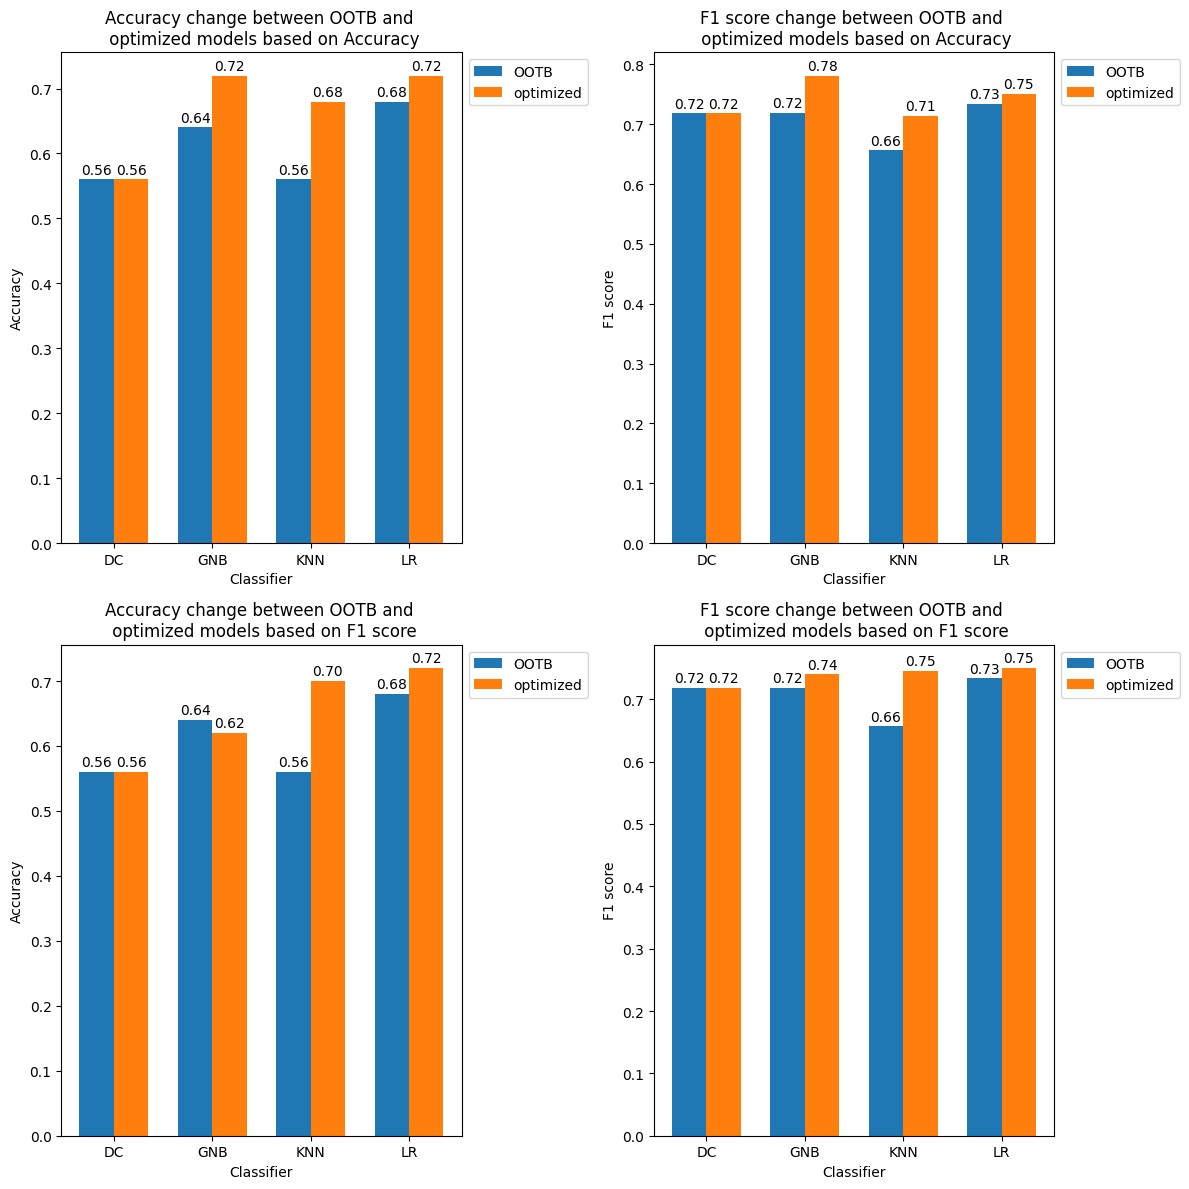

In [24]:
# plot bar charts for the changes in accuracy and f1 score based on accuracy and f1 score
zipped = zip([(0, 0), (0, 1), (1, 0), (1, 1)], 
             [ootb_accuracy, ootb_f1, ootb_accuracy, ootb_f1],
             [optimized_accuracy_acc, optimized_f1_acc, optimized_accuracy_f1, optimized_f1_f1],
             ["Accuracy", "F1 score", "Accuracy", "F1 score"],
             ["Accuracy", "Accuracy", "F1 score", "F1 score"])
             
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
x = np.arange(len(names))
width = 0.35

for index, ootb, optimized, scoring, base in zipped:
    rects1 = ax[index].bar(x - width/2, ootb.values(), width, label='OOTB')
    rects2 = ax[index].bar(x + width/2, optimized.values(), width, label='optimized')
    ax[index].set_ylabel(scoring)
    ax[index].set_xlabel("Classifier")
    ax[index].set_title(f"{scoring} change between OOTB and \n optimized models based on {base}")
    ax[index].set_xticks(x, names.keys())
    ax[index].legend(bbox_to_anchor=(1, 1))
    ax[index].bar_label(rects1, padding=2, fmt='%.2f')
    ax[index].bar_label(rects2, padding=2, fmt='%.2f')

fig.tight_layout()
plt.show()

On this plot, we can see the previous information about accuracy and F1 score of the best classifiers. Except for the Dummy Classifier where there was no optimization and the values have stayed the same for both OOTB and optimized models, the rest show an increase in most metrics. An outlier is the GNB model selected based on F1 score, where the accuracy has decreased, while the F1 score has increased. We can also see that the KNN model is the one that is showing the highest increases both in accuracy and in F1 score.

### Confusion Matrices

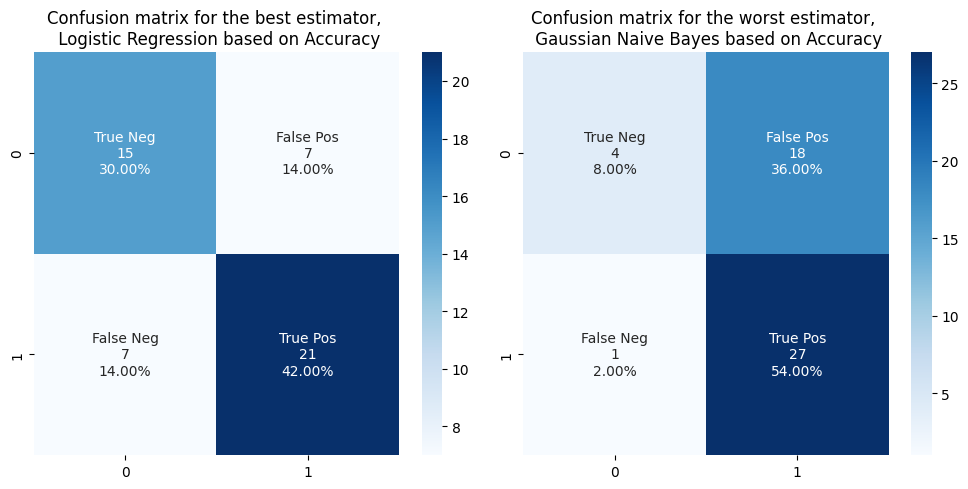

In [31]:
# print the confusion matrix for the best and worst model based on acurracy
zipped = zip([0, 1],
             [best_estimator, worst_estimator],
             ['best', 'worst'],
             ['LR', 'GNB'])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for index, estimator, kind, classifier in zipped:
    y_pred = estimator.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]).reshape(cf_matrix.shape[0],cf_matrix.shape[1])
    sns.heatmap(cf_matrix, annot=labels, fmt="", ax=ax[index], cmap='Blues')
    ax[index].set_title(f"Confusion matrix for the {kind} estimator, \n {names[classifier]} based on Accuracy")

fig.tight_layout()
plt.show()

As we can see on the confusion matrices, the best estimator according to the accuracy metric, the Logistic Regression model, has a good percentage of True Negative and True Positive classifications, while there is a balance of False Negatives and False Positives. However, it should be noted that False Positives are not ideal in this dataset, since that means that patients that did not live, were labeled as living. Therefore, False Positives should be kept to a minimum.

For the worst estimator, the Gaussian Naive Bayes, we can see that there is a really high percentage of False Positives. Therefore, the GNB model is not only a worse choice because of its lower accuracy, but because it has a high amount of False Positives as well, which should be avoided as explained above.

### Conclusion

All things considered, the Logistic Regression classifier seems to be the best overall choice for this dataset. It has the best accuracy and F1 score and it doesn't have a lot of False Positives. The train and test times are also kept within reasonable limits. There are not any obvious negatives of this classifier, that would point to any other one of the 4 being a better choice.